In [1]:
import numpy as np
import mne
import pickle
from mne.preprocessing import read_ica
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC, SVR

from tqdm import tqdm
from matplotlib import pyplot as plt

from continuous_control_bci.visualisation.erds import plot_tfr
from continuous_control_bci.util import emg_classes_to_eeg_classes, SUBJECT_IDS
from continuous_control_bci.data.load_data import load_calibration, load_driving
from continuous_control_bci.data.preprocessing import make_epochs, epochs_to_train_test
from continuous_control_bci.modelling.csp_classifier import create_csp_classifier, get_driving_epochs_for_csp
from sklearn.metrics import f1_score
from filterbank_csp import filter_bank, filter_bank_csp, predict_against_threshold, predict_against_threshold_indiv, create_csp_svm_classifier, majority_pred

In [5]:
# Subject 61 should have fairly good EEG data and performance
# Loading Calibration, apply ICA, make Epochs, Split
subject_id = "061"
include_rest = True
if include_rest:
    target_names = ["Left", "Right", "Rest"]
else:
    target_names = ["Left", "Right"]
raw = load_calibration(subject_id)
raw.set_eeg_reference()
raw.filter(l_freq=5, h_freq=35)
eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
ica.apply(raw)
epochs = make_epochs(raw, include_rest=include_rest)
X_train, _, y_train, _ = epochs_to_train_test(epochs)

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P061\motor-imagery-csp-061-acquisition-[2024.02.07-14.35.15].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter paramete

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P061-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


## Plotting the PSD
Clear peak can be seen around 10Hz for Left and Right and between 10-11 for Rest case

In [6]:
epochs['left'].compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch').plot(average=True)


Effective window size : 1.000 (s)
Averaging across epochs...


D:\Artificial Intelligence\Bac Thesis\Thesis_code\venv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Effective window size : 1.000 (s)
Averaging across epochs...


D:\Artificial Intelligence\Bac Thesis\Thesis_code\venv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


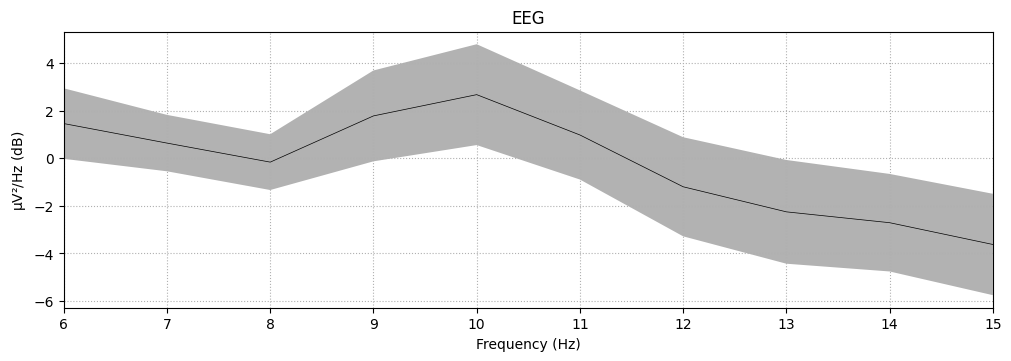

In [49]:
epochs['right'].compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch').plot(average=True)

Effective window size : 1.000 (s)
Averaging across epochs...


D:\Artificial Intelligence\Bac Thesis\Thesis_code\venv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


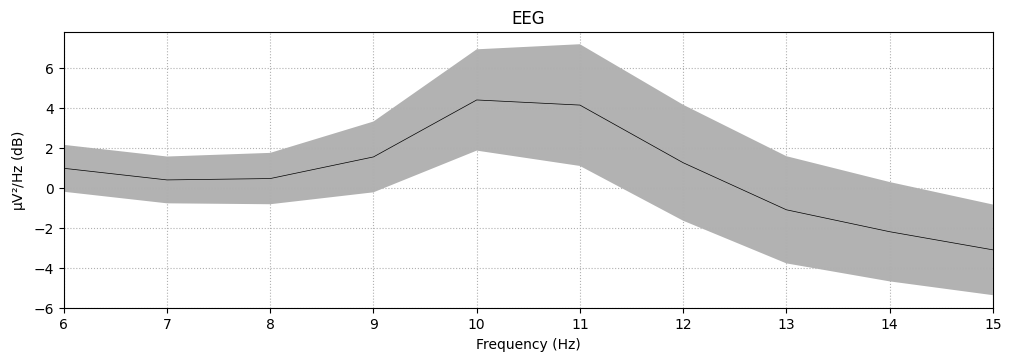

In [5]:
epochs['rest'].compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch').plot(average=True)

Effective window size : 1.000 (s)
Averaging across epochs...


D:\Artificial Intelligence\Bac Thesis\Thesis_code\venv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


AttributeError: 'MNELineFigure' object has no attribute 'save'

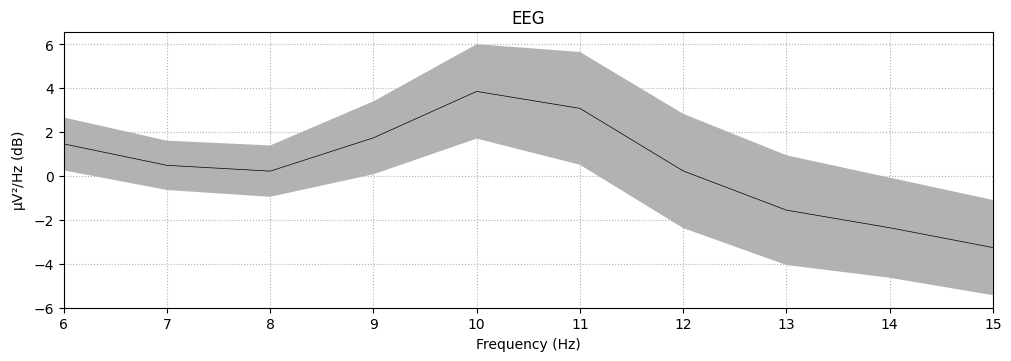

In [3]:
epochs.compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch').plot(average=True)
plt.savefig()

getting ERDs maps in C3, Cz, C4
tmin = -3.0
tmax = 5.0
buffer = 0.5
event_ids = dict(left=0, right=1)

raw = mne.preprocessing.compute_current_source_density(raw)

epochs = make_epochs(raw, tmin=tmin-buffer, tmax=tmax+buffer, include_rest=False)
epochs.pick(["C3", "C4"])


plot_tfr(epochs, subject_id, baseline=(-3, 0), tmin=tmin, tmax=tmax, event_ids=event_ids, kind='calibration')
plot_tfr(epochs, subject_id, baseline=None, tmin=tmin, tmax=tmax, event_ids=event_ids, kind='calibration')

## Setting the filter parameters to a fourth order butterworth filter for a 2Hz windows around 10Hz

In [4]:
iir_params = dict(order=4, ftype="butterworth", output='sos')
#iir_params = mne.filter.construct_iir_filter(iir_params, f_pass=[8,11], sfreq=2048, btype="bandpass")
X_train = mne.filter.filter_data(X_train, 2048, l_freq=9, h_freq=11,method='iir', iir_params=iir_params)

Setting up band-pass filter from 8 - 11 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 11.00 Hz: -6.02, -6.02 dB



Training both a Logistic regression and a SVC classifier

In [5]:
print("Training classifier. This may take a while..")
rank = {
    'eeg': X_train.shape[1] - len(ica.exclude),
    'mag': 32,
}
clf, y_pred = create_csp_classifier(X_train, y_train, rank)
svm_model, y_svm_pred = create_csp_svm_classifier(X_train, y_train, rank)
print("Classifier trained! \n")
print("Logistic Regression:")
print(classification_report(y_train, y_pred, target_names=target_names))
print("SVC Regression:")
print(classification_report(y_train, y_svm_pred, target_names=target_names))


Training classifier. This may take a while..
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.


## Loading the Driving data, applying the same filter
I apply the filter after creating the epochs as I feel like this is more true to what would happen in an online setting with an incoming data stream
The windwos Size of 2 seconds with a 1.8 second overlap is chosen as this I can barely run on my PC using around 14gb of Ram



In [6]:
# Loading the Driving data
driving = load_driving(subject_id)
driving.raw.set_eeg_reference()
driving.raw.filter(l_freq=5, h_freq=35)
ica.apply(driving.raw)

# EEG Data Stream
eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
eeg_data, eeg_time = driving.raw[eeg_channel_indices]
# Those windows are basically my epochs on which I try to predict something, if a certain amount of windows have the same prediction (3.5 sec or smth) this can then be used to controll the car
eeg_windows = mne.make_fixed_length_epochs(driving.raw, duration=2, overlap=1.8, preload=False, reject_by_annotation=False)

X_driving = eeg_windows.get_data(copy=False, picks=eeg_channel_indices)
X_driving = mne.filter.filter_data(X_driving, 2048, l_freq=8, h_freq=11,method='iir', iir_params=iir_params)
# Making predictions based on EEG windows
# -1 left, 0 rest, 1 right
y_driving = driving.emg_prediction_stream['time_series']
y_driving = emg_classes_to_eeg_classes(y_driving)
y_driving = np.squeeze(y_driving)
print(X_driving.shape)
print(y_driving[:-1].shape)

Creating RawArray with float64 data, n_channels=40, n_times=5494682
    Range : 0 ... 5494681 =      0.000 ...  2682.950 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.8s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13405 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13405 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 8 - 11 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 11.00 Hz: -6.02, -6.02 dB

(13405, 32, 4096)
(13414,)


In [ ]:
# This itself takes quite long to execute and i used to see if the alpha frequecny peak can also be seen in the driving data.
#eeg_windows.compute_tpsd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch').plot(average=True)

In [10]:
# currently the threshold is hardcoded to .3, this was done as most of the times i tried to run the code the best_t was very low and therefore only rest was predicted
threshold_samples = int(X_driving.shape[0] * 0.1)
ts = np.linspace(0, 1, 30)
t_scores = [f1_score(y_driving[:threshold_samples], predict_against_threshold(clf, X_driving[:threshold_samples], t), average='micro') for t in ts]
best_t = ts[np.argmax(t_scores)]
print(best_t)


0.034482758620689655


In [7]:
y_preds, y_majority_pred = majority_pred(X_driving, clf, 10)

print("Majority prediction of 2s windwos combined:")
print(classification_report(y_driving[::10][:-1], y_majority_pred, target_names=target_names))

              precision    recall  f1-score   support

        Left       0.54      0.93      0.68       444
       Right       0.67      0.69      0.68       290
        Rest       0.75      0.35      0.47       607

    accuracy                           0.61      1341
   macro avg       0.65      0.65      0.61      1341
weighted avg       0.66      0.61      0.59      1341



In [8]:
y_pred_normal = clf.predict(X_driving)

In [9]:
print("Compared at every prediction (200ms)")
print(classification_report(y_driving[:-10], y_pred_normal, target_names=target_names))

              precision    recall  f1-score   support

        Left       0.51      0.92      0.66      4338
       Right       0.56      0.63      0.59      2923
        Rest       0.73      0.26      0.38      6144

    accuracy                           0.56     13405
   macro avg       0.60      0.60      0.54     13405
weighted avg       0.62      0.56      0.52     13405



In [ ]:
# Take a look into why it is not generalizeable
# Plot spectrums of alpha frequency of the driving etc
# Find out why the EMG signals are longer and calculate the timepoints wether they are to be removed from the beginning or end.
# Removing breaks would only increase accuracy, as the algorithm is trained on calib data it should not influence anything else, that being said it needs to be implemented still.


# Applying to the other Subjects that worked well: 061, 381, 812
__TODO__: Use automatic detection of the peak alpha frequency, run for all participants to see if it maybe improves the ones that did not show good transferability

In [6]:
# Subject 61 should have fairly good EEG data and performance
# Loading Calibration, apply ICA, make Epochs, Split
subject_id = "381"
include_rest = True
if include_rest:
    target_names = ["Left", "Right", "Rest"]
else:
    target_names = ["Left", "Right"]
raw = load_calibration(subject_id)
raw.set_eeg_reference()
raw.filter(l_freq=5, h_freq=35)
eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
ica.apply(raw)
epochs = make_epochs(raw, include_rest=include_rest)
X_train, _, y_train, _ = epochs_to_train_test(epochs)

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P381\motor-imagery-csp-381-acquisition-[2024.02.09-09.37.02].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882655  =      0.000 ...   430.984 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter paramete

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P381-calibration-ica.fif ...
Now restoring ICA solution ...


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O2']
1 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['FC6', 'Fp2']
    Rejecting  epoch based on EEG : ['F7', 'Fp2']
    Rejecting  epoch based on EEG : ['F7', 'Fp2']
3 bad epochs dropped
Not setting metadata
76 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Averaging across epochs...


D:\Artificial Intelligence\Bac Thesis\Thesis_code\venv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


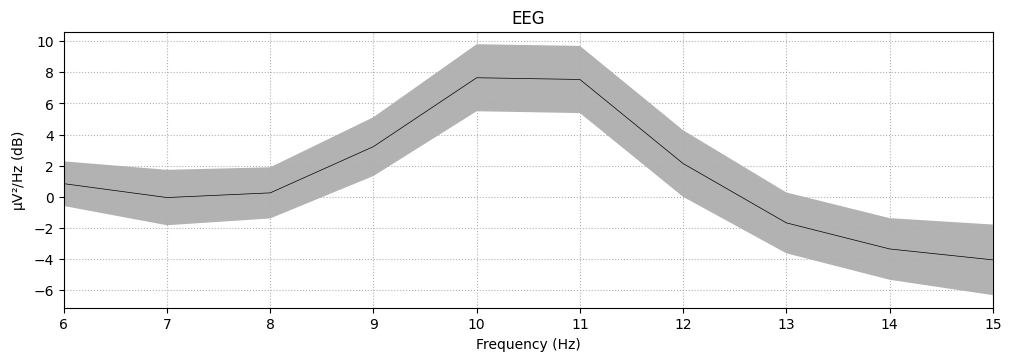

In [50]:
epochs['left'].compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch').plot(average=True)

Effective window size : 1.000 (s)
Averaging across epochs...


D:\Artificial Intelligence\Bac Thesis\Thesis_code\venv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


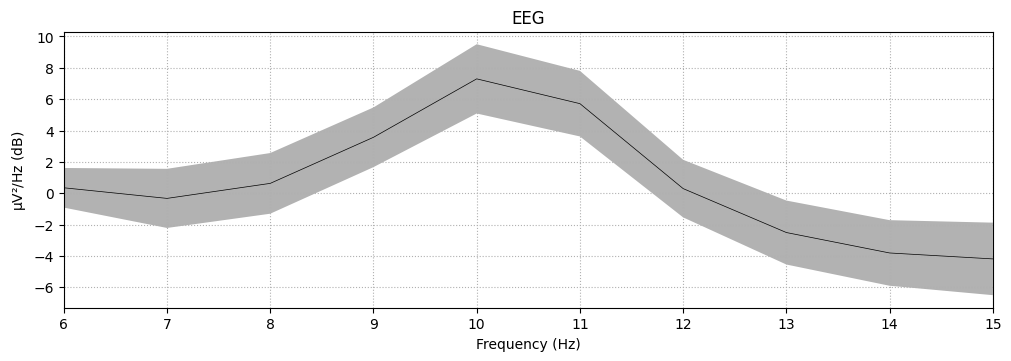

In [51]:
epochs['right'].compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch').plot(average=True)

Effective window size : 1.000 (s)
Averaging across epochs...


D:\Artificial Intelligence\Bac Thesis\Thesis_code\venv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


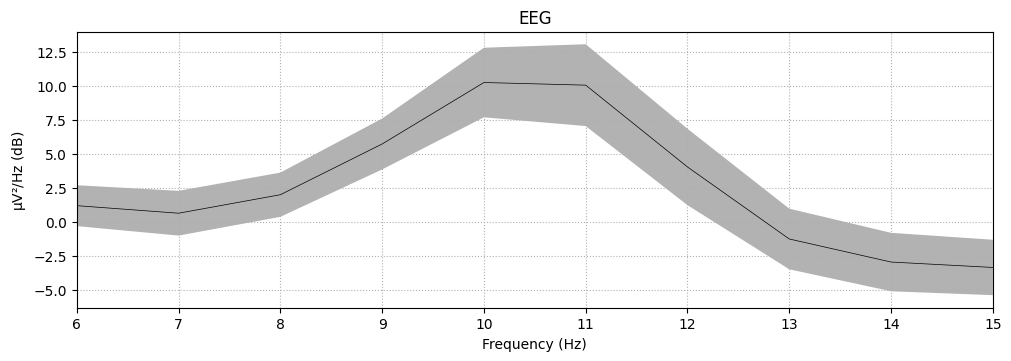

In [52]:
epochs['rest'].compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch').plot(average=True)

Effective window size : 1.000 (s)
Averaging across epochs...


D:\Artificial Intelligence\Bac Thesis\Thesis_code\venv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


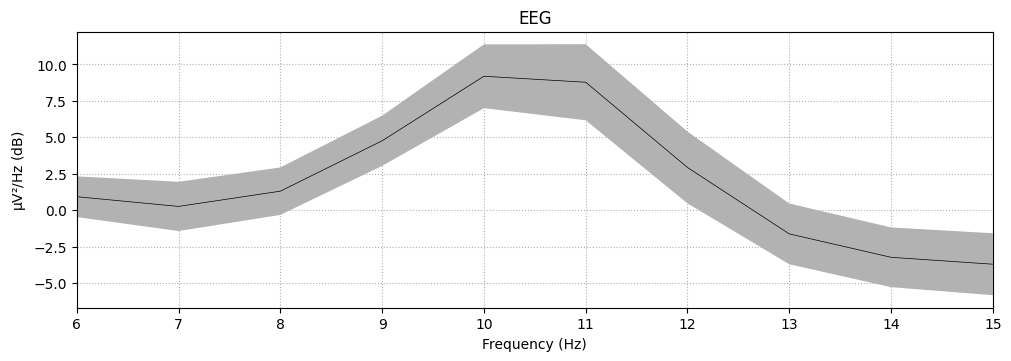

In [7]:
epochs.compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch').plot(average=True)

Also around 10-11Hz for participant 381


Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P812\motor-imagery-csp-812-acquisition-[2024.01.29-11.21.29].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882815  =      0.000 ...   431.062 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter paramete

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P812-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied
Effective window size : 1.000 (s)


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Averaging across epochs...


D:\Artificial Intelligence\Bac Thesis\Thesis_code\venv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


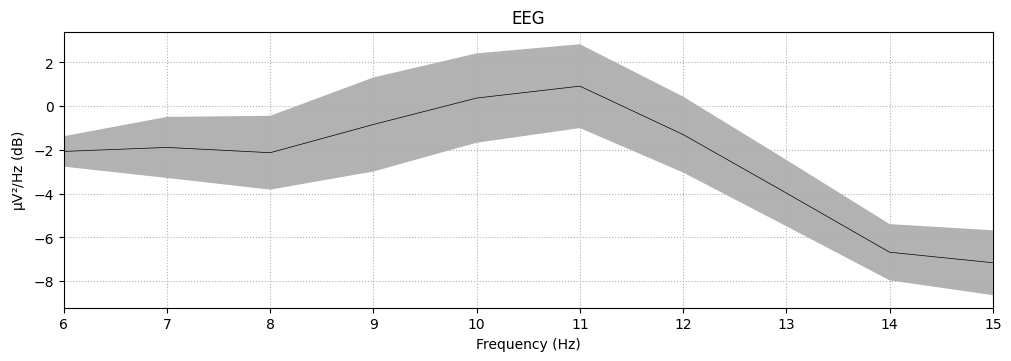

In [9]:
subject_id = "812"
raw = load_calibration(subject_id)
raw.set_eeg_reference()
raw.filter(l_freq=5, h_freq=35)
eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
ica.apply(raw)
epochs = make_epochs(raw, include_rest=include_rest)
epochs['left'].compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch').plot(average=True)

Effective window size : 1.000 (s)
Averaging across epochs...


D:\Artificial Intelligence\Bac Thesis\Thesis_code\venv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


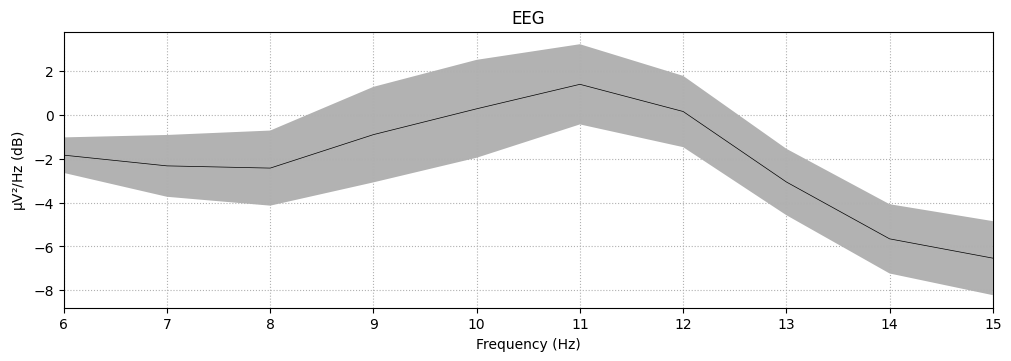

In [63]:
epochs['right'].compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch').plot(average=True)

Effective window size : 1.000 (s)
Averaging across epochs...


D:\Artificial Intelligence\Bac Thesis\Thesis_code\venv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


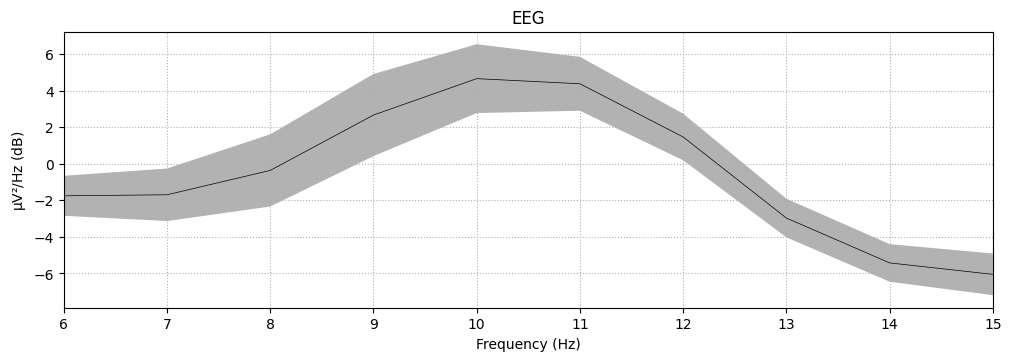

In [64]:
epochs['rest'].compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch').plot(average=True)

Effective window size : 1.000 (s)
Averaging across epochs...


D:\Artificial Intelligence\Bac Thesis\Thesis_code\venv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


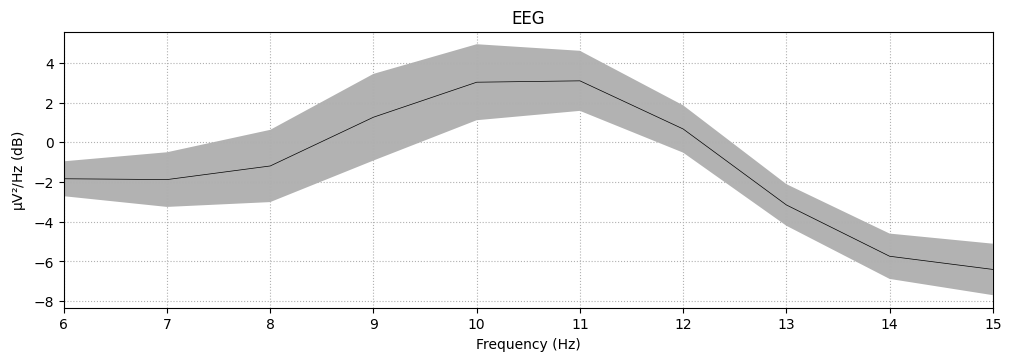

In [10]:
epochs.compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch').plot(average=True)

Participant 812 has the peak more at 11Hz than 10.


In [3]:
subject_ids = ['061', '381', '812'] #
filters = [[9,11], [9,11], [10,12]] #

for i, subject_id in enumerate(tqdm(subject_ids)):
    # Subject 61 should have fairly good EEG data and performance
    include_rest = True
    raw = load_calibration(subject_id)
    raw.set_eeg_reference()
    iir_params = dict(order=4, ftype="butterworth", output='sos')
    raw.filter(l_freq=filters[i][0], h_freq=filters[i][1], method='iir', iir_params=iir_params)

    ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
    ica.apply(raw)

    epochs = make_epochs(raw, include_rest=include_rest)

    X_train, _, y_train, _ = epochs_to_train_test(epochs)
    print("Training classifier. This may take a while..")
    rank = {
        'eeg': X_train.shape[1] - len(ica.exclude),
        'mag': 32,
    }
    clf, y_pred = create_csp_classifier(X_train, y_train, rank)
    svm_model, y_svm_pred = create_csp_svm_classifier(X_train, y_train, rank)
    print("Classifier trained!")

    # Loading the Driving data
    driving = load_driving(subject_id)
    driving.raw.set_eeg_reference()
    driving.raw.filter(l_freq=5, h_freq=35)
    ica.apply(driving.raw)

    # EEG Data Stream
    eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
    eeg_data, eeg_time = driving.raw[eeg_channel_indices]
    # Those windows are basically my epochs on which I try to predict something, if a certain amount of windows have the same prediction (3.5 sec or smth) this can then be used to controll the car
    eeg_windows = mne.make_fixed_length_epochs(driving.raw, duration=2,overlap=1.8, preload=True, reject_by_annotation=False)
    X_driving = eeg_windows.get_data(copy=False, picks=eeg_channel_indices)
    X_driving = mne.filter.filter_data(X_driving, 2048, l_freq=filters[i][0], h_freq=filters[i][1],method='iir', iir_params=iir_params)


    # EMG Stream
    # -1 left, 0 rest, 1 right
    y_driving = driving.emg_prediction_stream['time_series']
    y_driving = emg_classes_to_eeg_classes(y_driving)
    # 0 left, 1 right, 2 rest
    y_driving = np.squeeze(y_driving)
    print("Shape of y_driving before adjusting",y_driving.shape)
    print("Shape of X_driving before adjustment", X_driving.shape)
    if X_driving.shape[0] == y_driving.shape[0]:
        pass
    elif X_driving.shape[0] > y_driving.shape[0]:
        diff = X_driving.shape[0]-y_driving.shape[0]
        X_driving = X_driving[:-diff,:,:]
    else:
        diff = y_driving.shape[0]-X_driving.shape[0]
        y_driving = y_driving[:-diff]
    #print(X_driving.shape)
    #print(y_driving[:-1].shape)
    y_preds, y_majority_pred = majority_pred(X_driving, clf, 10)
    print("Shape of y-driving after adjustment",y_driving[::10].shape)
    print("Shape of Majority_pred",y_majority_pred.shape)
    report = classification_report(y_driving[::10], y_majority_pred, target_names=["Left", "Right", "Rest"], output_dict=True)
    print(report)
    with open(f'./data/report_IAF_{subject_id}_1.pkl', 'wb') as fp:
        pickle.dump(report, fp)#

  0%|          | 0/3 [00:00<?, ?it/s]

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P061\motor-imagery-csp-061-acquisition-[2024.02.07-14.35.15].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

IIR filter paramete

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (wi

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.7s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13405 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13405 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 9 - 11 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 9.00, 11.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (13415,)
Shape of X_driving before adjustment (13405, 32, 4096)


 33%|███▎      | 1/3 [13:26<26:52, 806.13s/it]

Shape of y-driving after adjustment (1341,)
Shape of Majority_pred (1341,)
{'Left': {'precision': 0.5162064825930373, 'recall': 0.9684684684684685, 'f1-score': 0.6734534064213, 'support': 444}, 'Right': {'precision': 0.6645962732919255, 'recall': 0.7379310344827587, 'f1-score': 0.6993464052287582, 'support': 290}, 'Rest': {'precision': 0.8440860215053764, 'recall': 0.2586490939044481, 'f1-score': 0.3959646910466583, 'support': 607}, 'accuracy': 0.5973154362416108, 'macro avg': {'precision': 0.6749629257967796, 'recall': 0.6550161989518918, 'f1-score': 0.5895881675655722, 'support': 1341}, 'weighted avg': {'precision': 0.6967105239222449, 'recall': 0.5973154362416108, 'f1-score': 0.5534484246328998, 'support': 1341}}
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P381\motor-imagery-csp-381-acquisition-[2024.02.09-09.37.02].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
C

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Training classifier. This may take a while..
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.7s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12963 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12963 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 9 - 11 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 9.00, 11.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (12973,)
Shape of X_driving before adjustment (12963, 32, 4096)


 67%|██████▋   | 2/3 [27:58<14:05, 845.22s/it]

Shape of y-driving after adjustment (1297,)
Shape of Majority_pred (1297,)
{'Left': {'precision': 0.5755287009063444, 'recall': 0.8839907192575406, 'f1-score': 0.6971637694419031, 'support': 431}, 'Right': {'precision': 0.5887323943661972, 'recall': 0.7491039426523297, 'f1-score': 0.6593059936908517, 'support': 279}, 'Rest': {'precision': 0.6392857142857142, 'recall': 0.3049403747870528, 'f1-score': 0.41291810841983856, 'support': 587}, 'accuracy': 0.5929067077872012, 'macro avg': {'precision': 0.6011822698527519, 'recall': 0.6460116788989744, 'f1-score': 0.5897959571841979, 'support': 1297}, 'weighted avg': {'precision': 0.6072243040898363, 'recall': 0.5929067077872012, 'f1-score': 0.5603753943806116, 'support': 1297}}
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P812\motor-imagery-csp-812-acquisition-[2024.01.29-11.21.29].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EE

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.2s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
14030 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14030 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 11 - 13 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 11.00, 13.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (14040,)
Shape of X_driving before adjustment (14030, 32, 4096)


100%|██████████| 3/3 [44:33<00:00, 891.24s/it]

Shape of y-driving after adjustment (1403,)
Shape of Majority_pred (1403,)
{'Left': {'precision': 0.6754716981132075, 'recall': 0.3934065934065934, 'f1-score': 0.4972222222222221, 'support': 455}, 'Right': {'precision': 0.6118012422360248, 'recall': 0.654485049833887, 'f1-score': 0.6324237560192616, 'support': 301}, 'Rest': {'precision': 0.5588235294117647, 'recall': 0.7047913446676971, 'f1-score': 0.6233766233766235, 'support': 647}, 'accuracy': 0.5930149679258732, 'macro avg': {'precision': 0.6153654899203324, 'recall': 0.5842276626360592, 'f1-score': 0.5843408672060358, 'support': 1403}, 'weighted avg': {'precision': 0.6080189736877867, 'recall': 0.5930149679258732, 'f1-score': 0.5844050869547999, 'support': 1403}}


In [2]:
subject_ids = ['061', '381', '812']
for subject_id in subject_ids:
    with open(f'./data/report_IAF_{subject_id}.pkl', "rb") as fp:
        report = pickle.load(fp)
        print(f"Subject {subject_id}")
        print("Left f1-score", report['Left']["f1-score"])
        print("Right f1-score", report['Right']["f1-score"])
        print("Rest f1-score", report['Rest']["f1-score"])
        print("Accuracy f1-score", report['accuracy'])
        print("\n")

Subject 061
Left f1-score 0.6586414445399829
Right f1-score 0.568
Rest f1-score 0.4985279685966634
Accuracy f1-score 0.580909768829232


Subject 381
Left f1-score 0.6870229007633587
Right f1-score 0.6312178387650086
Rest f1-score 0.4735202492211838
Accuracy f1-score 0.5952197378565921


Subject 812
Left f1-score 0.36257309941520466
Right f1-score 0.5124653739612188
Rest f1-score 0.5214285714285714
Accuracy f1-score 0.4803991446899501




In [3]:
subject_ids = ['061', '381', '812']
for subject_id in subject_ids:
    with open(f'./data/report_IAF_{subject_id}_1.pkl', "rb") as fp:
        report = pickle.load(fp)
        print(f"Subject {subject_id}")
        print("Left f1-score", report['Left']["f1-score"])
        print("Right f1-score", report['Right']["f1-score"])
        print("Rest f1-score", report['Rest']["f1-score"])
        print("Accuracy f1-score", report['accuracy'])
        print("\n")

Subject 061
Left f1-score 0.6734534064213
Right f1-score 0.6993464052287582
Rest f1-score 0.3959646910466583
Accuracy f1-score 0.5973154362416108


Subject 381
Left f1-score 0.6971637694419031
Right f1-score 0.6593059936908517
Rest f1-score 0.41291810841983856
Accuracy f1-score 0.5929067077872012


Subject 812
Left f1-score 0.4972222222222221
Right f1-score 0.6324237560192616
Rest f1-score 0.6233766233766235
Accuracy f1-score 0.5930149679258732




In [4]:
for subject_id in subject_ids:
    with open(f'report_sliding_{subject_id}_2s.pkl', "rb") as fp:
        report = pickle.load(fp)
        print(f"Subject {subject_id}")
        print("Left f1-score", report['Left']["f1-score"])
        print("Right f1-score", report['Right']["f1-score"])
        print("Rest f1-score", report['Rest']["f1-score"])
        print("Accuracy f1-score", report['accuracy'])
        print("\n")

Subject 061
Left f1-score 0.6934244235695987
Right f1-score 0.6584507042253521
Rest f1-score 0.5153764581124072
Accuracy f1-score 0.6234153616703952


Subject 381
Left f1-score 0.6713426853707415
Right f1-score 0.6396255850234009
Rest f1-score 0.4586387434554974
Accuracy f1-score 0.5851966075558982


Subject 812
Left f1-score 0.4774535809018568
Right f1-score 0.6348733233979136
Rest f1-score 0.5749456915278783
Accuracy f1-score 0.5630791161796151




#### Comparison
This comparison shows that there is not much gain in using the individual frequency, at least not for the participants that already had good results. We do see minor improvements across the three subjects

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P061\motor-imagery-csp-061-acquisition-[2024.02.07-14.35.15].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=40, n_times=5494682
    Range : 0 ... 5494681 =      0.000

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.7s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P061-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13405 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13405 events and 4096 original time points ...
0 bad epochs dropped
Effective window size : 1.000 (s)
Averaging across epochs...


D:\Artificial Intelligence\Bac Thesis\Thesis_code\venv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P381\motor-imagery-csp-381-acquisition-[2024.02.09-09.37.02].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882655  =      0.000 ...   430.984 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=40, n_times=5313379
    Range : 0 ... 5313378 =      0.000

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.6s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P381-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12963 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12963 events and 4096 original time points ...
0 bad epochs dropped
Effective window size : 1.000 (s)
Averaging across epochs...


D:\Artificial Intelligence\Bac Thesis\Thesis_code\venv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P812\motor-imagery-csp-812-acquisition-[2024.01.29-11.21.29].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882815  =      0.000 ...   431.062 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=40, n_times=5750675
    Range : 0 ... 5750674 =      0.000

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.0s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P812-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
14030 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14030 events and 4096 original time points ...
0 bad epochs dropped
Effective window size : 1.000 (s)
Averaging across epochs...


D:\Artificial Intelligence\Bac Thesis\Thesis_code\venv\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


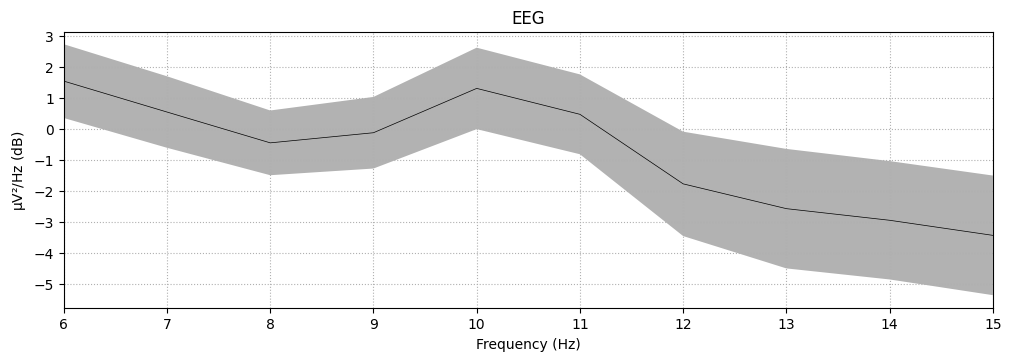

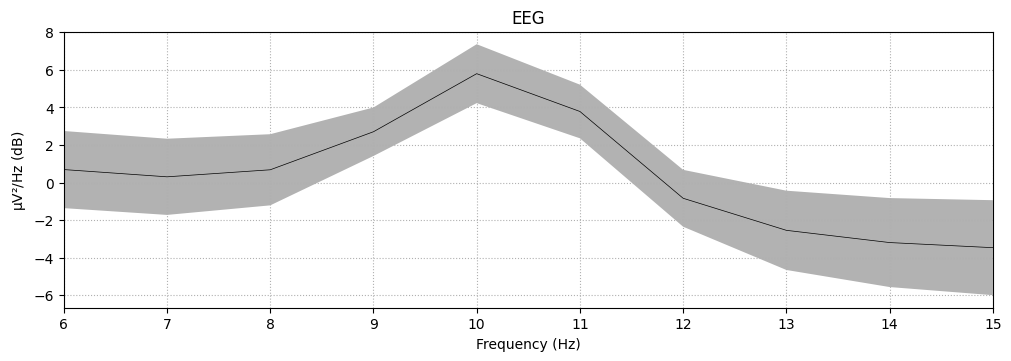

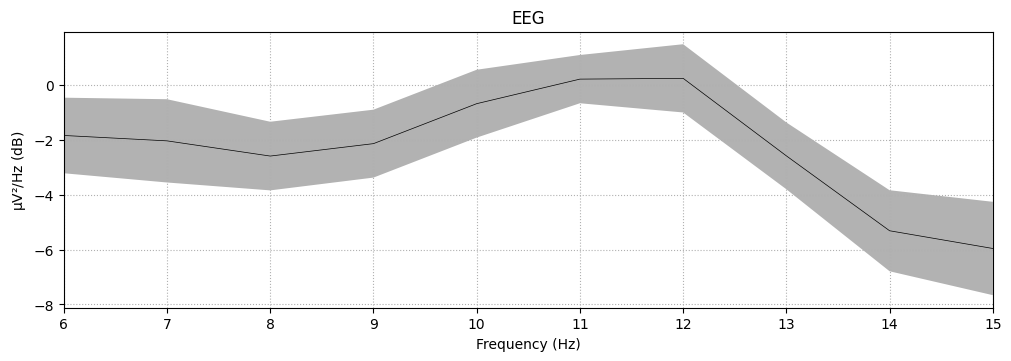

In [5]:
subject_ids = ['061', '381', '812']
# Loading the Driving data
for subject_id in subject_ids:
    raw = load_calibration(subject_id)
    raw.set_eeg_reference()
    driving = load_driving(subject_id)
    driving.raw.set_eeg_reference()
    driving.raw.filter(l_freq=5, h_freq=35)
    ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
    ica.apply(driving.raw)

    # EEG Data Stream
    eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
    eeg_data, eeg_time = driving.raw[eeg_channel_indices]
    # Those windows are basically my epochs on which I try to predict something, if a certain amount of windows have the same prediction (3.5 sec or smth) this can then be used to controll the car
    eeg_windows = mne.make_fixed_length_epochs(driving.raw, duration=2, overlap=1.8, preload=False, reject_by_annotation=False)
    eeg_windows.compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch').plot(average=True)
    plt.savefig(f"psd_plot_{subject_id}.pdf")

# Flipping Training and Testing Set
So we use the driving data as training and test on the epochs of the calib data. My guess is that the performance will be better as we have more clear patterns when using predifined epochs.

In [2]:
 # Loading the Driving data
filters = [[9,11], [9,11], [10,12]]
subject_ids = ['061', '381','812']
for i, subject_id in enumerate(tqdm(subject_ids)):
    include_rest = True
    iir_params = dict(order=4, ftype="butterworth", output='sos')
    driving = load_driving(subject_id)
    driving.raw.set_eeg_reference()
    driving.raw.filter(l_freq=5, h_freq=35)
    ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
    ica.apply(driving.raw)

    # EEG Data Stream
    eeg_channel_indices = mne.pick_types(driving.raw.info, eeg=True, emg=False)
    # Those windows are basically my epochs on which I try to predict something, if a certain amount of windows have the same prediction (3.5 sec or smth) this can then be used to controll the car
    eeg_windows = mne.make_fixed_length_epochs(driving.raw, duration=2,overlap=1.8, preload=True, reject_by_annotation=False)
    eeg_windows = eeg_windows.resample(1024)
    X_driving = eeg_windows.get_data(copy=False, picks=eeg_channel_indices)
    X_driving = mne.filter.filter_data(X_driving, 1024, l_freq=filters[i][0], h_freq=filters[i][1],method='iir', iir_params=iir_params)


    # EMG Stream
    # -1 left, 0 rest, 1 right
    y_driving = driving.emg_prediction_stream['time_series']
    y_driving = emg_classes_to_eeg_classes(y_driving)
    # 0 left, 1 right, 2 rest
    y_driving = np.squeeze(y_driving)
    print("Shape of y_driving before adjusting",y_driving.shape)
    print("Shape of X_driving before adjustment", X_driving.shape)
    if X_driving.shape[0] == y_driving.shape[0]:
        pass
    elif X_driving.shape[0] > y_driving.shape[0]:
        diff = X_driving.shape[0]-y_driving.shape[0]
        X_driving = X_driving[:-diff,:,:]
    else:
        diff = y_driving.shape[0]-X_driving.shape[0]
        y_driving = y_driving[:-diff]
        rank = {
            'eeg': X_driving.shape[1] - len(ica.exclude),
            'mag': 32,
        }
    clf, y_driving_pred = create_csp_classifier(X_driving, y_driving, rank)
    train_report = classification_report(y_driving, y_driving_pred, target_names=["Left", "Right", "Rest"], output_dict=True)
    print(classification_report(y_driving, y_driving_pred, target_names=["Left", "Right", "Rest"], output_dict=False))
    with open(f'./data/train_driving_IAF_{subject_id}.pkl', 'wb') as fp:
        pickle.dump(train_report, fp)
    raw = load_calibration(subject_id)
    raw.set_eeg_reference()
    iir_params = dict(order=4, ftype="butterworth", output='sos')
    raw.filter(l_freq=filters[0][0], h_freq=filters[0][1], method='iir', iir_params=iir_params)
    ica.apply(raw)

    epochs = make_epochs(raw, include_rest=include_rest)

    X_calib, _, y_calib, _ = epochs_to_train_test(epochs)
    calib_pred = clf.predict(X_calib)
    print(classification_report(y_calib, calib_pred, target_names=["Left", "Right", "Rest"], output_dict=False))
    test_report = classification_report(y_calib, calib_pred, target_names=["Left", "Right", "Rest"], output_dict=True)
    with open(f'./data/train_test_reversed_IAF_{subject_id}.pkl', 'wb') as fp:
        pickle.dump(test_report, fp)

  0%|          | 0/3 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=40, n_times=5494682
    Range : 0 ... 5494681 =      0.000 ...  2682.950 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.8s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P061-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13405 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13405 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 9 - 11 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 9.00, 11.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (13415,)
Shape of X_driving before adjustment (13405, 32, 2048)
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covari

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
 33%|███▎      | 1/3 [22:39<45:19, 1359.86s/it]

              precision    recall  f1-score   support

        Left       1.00      0.30      0.46        20
       Right       0.92      0.55      0.69        20
        Rest       0.65      1.00      0.78        40

    accuracy                           0.71        80
   macro avg       0.85      0.62      0.64        80
weighted avg       0.80      0.71      0.68        80

Creating RawArray with float64 data, n_channels=40, n_times=5313379
    Range : 0 ... 5313378 =      0.000 ...  2594.423 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.1s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P381-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12963 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12963 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 9 - 11 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 9.00, 11.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (12973,)
Shape of X_driving before adjustment (12963, 32, 2048)
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covari

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
 67%|██████▋   | 2/3 [44:45<22:19, 1339.54s/it]

              precision    recall  f1-score   support

        Left       1.00      0.45      0.62        20
       Right       0.81      0.65      0.72        20
        Rest       0.67      0.93      0.78        40

    accuracy                           0.74        80
   macro avg       0.83      0.68      0.71        80
weighted avg       0.79      0.74      0.73        80

Creating RawArray with float64 data, n_channels=40, n_times=5750675
    Range : 0 ... 5750674 =      0.000 ...  2807.946 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.3s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P812-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
14030 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14030 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 10 - 12 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 10.00, 12.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (14040,)
Shape of X_driving before adjustment (14030, 32, 2048)
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating cova

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
100%|██████████| 3/3 [1:09:32<00:00, 1390.96s/it]

              precision    recall  f1-score   support

        Left       1.00      0.15      0.26        20
       Right       0.00      0.00      0.00        20
        Rest       0.53      1.00      0.69        40

    accuracy                           0.54        80
   macro avg       0.51      0.38      0.32        80
weighted avg       0.51      0.54      0.41        80



raw = load_calibration(subject_id)
raw.set_eeg_reference()
iir_params = dict(order=4, ftype="butterworth", output='sos')
raw.filter(l_freq=filters[0][0], h_freq=filters[0][1], method='iir', iir_params=iir_params)
ica.apply(raw)

epochs = make_epochs(raw, include_rest=include_rest)

X_calib, _, y_calib, _ = epochs_to_train_test(epochs)
calib_pred = clf.predict(X_calib)
print(classification_report(y_calib, calib_pred, target_names=["Left", "Right", "Rest"], output_dict=True))

print(classification_report(y_calib, calib_pred, target_names=["Left", "Right", "Rest"], output_dict=False))

## Binary Case for Individual Frequency

In [6]:
filters = []
for subject_id in SUBJECT_IDS:
    include_rest = True
    if include_rest:
        target_names = ["Left", "Right", "Rest"]
    else:
        target_names = ["Left", "Right"]
    raw = load_calibration(subject_id)
    raw.set_eeg_reference()
    raw.filter(l_freq=5, h_freq=35)
    eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
    ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
    ica.apply(raw)
    epochs = make_epochs(raw, include_rest=include_rest)
    psd = epochs.compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch')
    psd_data = np.mean(psd.get_data(), axis=0)
    psd_data = np.mean(psd_data, axis=0)
    filters.append([psd.freqs[np.argmax(psd_data)]-1, psd.freqs[np.argmax(psd_data)]+1])

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P061\motor-imagery-csp-061-acquisition-[2024.02.07-14.35.15].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter paramete

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P061-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P066\motor-imagery-csp-066-acquisition-[2024.01.30-18.30.01].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882815  =      0.000 ...   431.062 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P066-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
2 bad epochs dropped
Not setting metadata
78 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P126\motor-imagery-csp-126-acquisition-[2024.02.08-15.59.48].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P126-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 6 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['O2']
5 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O1', 'O2']
    Rejecting  epoch based on EEG : ['PO4', 'CP6', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['O2', 'PO4', 'P8']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2', 'PO4']
    Rejecting  epoch based on EEG : ['O1']
    Reject

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P280\motor-imagery-csp-280-acquisition-[2024.02.02-16.08.52].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P280-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
1 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
79 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P302\motor-imagery-csp-302-acquisition-[2024.02.06-17.52.04].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882687  =      0.000 ...   431.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P302-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FC5']
2 bad epochs dropped
Not setting metadata
78 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P336\motor-imagery-csp-336-acquisition-[2024.02.08-14.04.05].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882751  =      0.000 ...   431.031 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P336-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P381\motor-imagery-csp-381-acquisition-[2024.02.09-09.37.02].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882655  =      0.000 ...   430.984 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P381-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O2']
1 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['FC6', 'Fp2']
    Rejecting  epoch based on EEG : ['F7', 'Fp2']
    Rejecting  epoch based on EEG : ['F7', 'Fp2']
3 bad epochs dropped
Not setting metadata
76 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P406\motor-imagery-csp-406-acquisition-[2024.02.06-11.06.31].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P406-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
3 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4']
    Rejecting  epoch based on EEG : ['O2']
7 bad epochs dropped
Not setting metadata
70 matchin

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P530\motor-imagery-csp-530-acquisition-[2024.02.02-12.04.47].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P530-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 7 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'C4', 'T8', 'FC6', 'F4']
1 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
79 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P587\motor-imagery-csp-587-acquisition-[2024.01.30-14.39.50].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882687  =      0.000 ...   431.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P587-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P643\motor-imagery-csp-643-acquisition-[2024.02.06-14.59.12].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882815  =      0.000 ...   431.062 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P643-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P656\motor-imagery-csp-656-acquisition-[2024.02.08-09.39.52].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P656-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 6 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['Fp2']
1 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['Fp2']
1 bad epochs dropped
Not setting metadata
78 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P744\motor-imagery-csp-744-acquisition-[2024.02.05-14.17.28].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P744-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P812\motor-imagery-csp-812-acquisition-[2024.01.29-11.21.29].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882815  =      0.000 ...   431.062 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P812-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P840\motor-imagery-csp-840-acquisition-[2024.01.23-14.39.09].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882815  =      0.000 ...   431.062 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P840-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 7 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['F4', 'F8']
    Rejecting  epoch based on EEG : ['O2']
2 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['FC6', 'F4']
    Rejecting  epoch based on EEG : ['F8']
2 bad epochs dropped
Not setting metadata
76 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P854\motor-imagery-csp-854-acquisition-[2024.01.30-10.40.45].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P854-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['F8', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F7', 'O1', 'O2', 'FC6', 'F4', 'F8', 'AF4', 'Fp2']
2 bad epochs dropped
Not setting metadata
78 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P968\motor-imagery-csp-968-acquisition-[2024.02.05-10.45.31].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P968-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.3s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['CP6', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['FC5']
2 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['P8', 'CP6', 'T8']
3 bad epochs dropped
Not setting metadata
75 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P986\motor-imagery-csp-986-acquisition-[2024.01.25-10.26.11].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P986-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)


In [7]:
subject_ids = ['061', '381', '812'] #
#filters = [[9,11], [9,11], [11,13]] #

for i, subject_id in enumerate(tqdm(SUBJECT_IDS)):
    # Subject 61 should have fairly good EEG data and performance
    include_rest = False
    if include_rest:
        target_names = ["Left", "Right", "Rest"]
    else:
        target_names = ["Left", "Right"]
    raw = load_calibration(subject_id)
    raw.set_eeg_reference()
    iir_params = dict(order=4, ftype="butterworth", output='sos')
    raw.filter(l_freq=filters[i][0], h_freq=filters[i][1], method='iir', iir_params=iir_params)

    ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
    ica.apply(raw)

    epochs = make_epochs(raw, include_rest=include_rest)

    X_train, _, y_train, _ = epochs_to_train_test(epochs)
    print("Training classifier. This may take a while..")
    rank = {
        'eeg': X_train.shape[1] - len(ica.exclude),
        'mag': 32,
    }
    clf, y_pred = create_csp_classifier(X_train, y_train, rank)
    svm_model, y_svm_pred = create_csp_svm_classifier(X_train, y_train, rank)
    print("Classifier trained!")

    # Loading the Driving data
    driving = load_driving(subject_id)
    driving.raw.set_eeg_reference()
    driving.raw.filter(l_freq=5, h_freq=35)
    ica.apply(driving.raw)

    # EEG Data Stream
    eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
    eeg_data, eeg_time = driving.raw[eeg_channel_indices]
    # Those windows are basically my epochs on which I try to predict something, if a certain amount of windows have the same prediction (3.5 sec or smth) this can then be used to controll the car
    eeg_windows = mne.make_fixed_length_epochs(driving.raw, duration=2,overlap=1.8, preload=True, reject_by_annotation=False)
    # Downsampling the data so it takes less time
    eeg_windows = eeg_windows.resample(1024)
    X_driving = eeg_windows.get_data(copy=False, picks=eeg_channel_indices)
    X_driving = mne.filter.filter_data(X_driving, 1024, l_freq=filters[i][0], h_freq=filters[i][1],method='iir', iir_params=iir_params)

    # EMG Stream
    # -1 left, 0 rest, 1 right
    y_driving = driving.emg_prediction_stream['time_series']
    y_driving = emg_classes_to_eeg_classes(y_driving)
    # 0 left, 1 right, 2 rest
    y_driving = np.squeeze(y_driving)
    print("Shape of y_driving before adjusting",y_driving.shape)
    print("Shape of X_driving before adjustment", X_driving.shape)
    if X_driving.shape[0] == y_driving.shape[0]:
        pass
    elif X_driving.shape[0] > y_driving.shape[0]:
        diff = X_driving.shape[0]-y_driving.shape[0]
        X_driving = X_driving[:-diff,:,:]
    else:
        diff = y_driving.shape[0]-X_driving.shape[0]
        y_driving = y_driving[:-diff]
    X_driving = X_driving[(y_driving == 0) |( y_driving == 1)]
    y_driving = y_driving[(y_driving == 0) |( y_driving == 1)]
    #print(X_driving.shape)
    #print(y_driving[:-1].shape)
    y_preds = clf.predict(X_driving)
    count = [0,0]
    maj_pred = []
    for i, pred in enumerate(y_preds):
        count[pred] += 1
        if i % 10 == 0:
            maj_pred.append(count.index(max(count)))
            count = [0,0]
    maj_pred = np.asarray(maj_pred)
    #y_preds, y_majority_pred = majority_pred(X_driving, clf, 10)
    print("Shape of y-driving after adjustment",y_driving[::10].shape)
    print("Shape of Majority_pred",maj_pred.shape)
    report = classification_report(y_driving[::10], maj_pred, target_names=target_names, output_dict=True)
    print(report)
    with open(f'./data/report_IAF_{subject_id}_binary.pkl', 'wb') as fp:
        pickle.dump(report, fp)#

  0%|          | 0/18 [00:00<?, ?it/s]

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P061\motor-imagery-csp-061-acquisition-[2024.02.07-14.35.15].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

IIR filter paramete

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.7s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13405 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13405 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 9 - 11 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 9.00, 11.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (13415,)
Shape of X_driving before adjustment (13405, 32, 2048)


  6%|▌         | 1/18 [08:36<2:26:15, 516.19s/it]

Shape of y-driving after adjustment (727,)
Shape of Majority_pred (727,)
{'Left': {'precision': 0.7486631016042781, 'recall': 0.9836065573770492, 'f1-score': 0.8502024291497975, 'support': 427}, 'Right': {'precision': 0.9578313253012049, 'recall': 0.53, 'f1-score': 0.6824034334763948, 'support': 300}, 'accuracy': 0.796423658872077, 'macro avg': {'precision': 0.8532472134527415, 'recall': 0.7568032786885246, 'f1-score': 0.7663029313130961, 'support': 727}, 'weighted avg': {'precision': 0.8349773617268063, 'recall': 0.796423658872077, 'f1-score': 0.7809593772900716, 'support': 727}}
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P066\motor-imagery-csp-066-acquisition-[2024.01.30-18.30.01].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Chan

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    2.3s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Not setting metadata
8268 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8268 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 10 - 12 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 10.00, 12.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (8278,)
Shape of X_driving before adjustment (8268, 32, 2048)
Shape of y-driving after adjustment (432,)
Shape of Majority_pred (432,)
{'Left': {'precision': 0.8129770992366412, 'recall': 0.8160919540229885, 'f1-score': 0.8145315487571702, 'support': 261}, 'Right': {'precision': 0.7176470588235294, 'recall': 0.7134502923976608, '

 11%|█         | 2/18 [12:34<1:34:00, 352.52s/it]

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P126\motor-imagery-csp-126-acquisition-[2024.02.08-15.59.48].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 12 Hz

IIR filter paramet

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.9s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 6 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13210 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13210 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 10 - 12 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 10.00, 12.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (13220,)
Shape of X_driving before adjustment (13210, 32, 2048)


 17%|█▋        | 3/18 [22:09<1:53:35, 454.39s/it]

Shape of y-driving after adjustment (795,)
Shape of Majority_pred (795,)
{'Left': {'precision': 0.8707692307692307, 'recall': 0.6099137931034483, 'f1-score': 0.7173637515842839, 'support': 464}, 'Right': {'precision': 0.6148936170212767, 'recall': 0.8731117824773413, 'f1-score': 0.721598002496879, 'support': 331}, 'accuracy': 0.7194968553459119, 'macro avg': {'precision': 0.7428314238952537, 'recall': 0.7415127877903949, 'f1-score': 0.7194808770405814, 'support': 795}, 'weighted avg': {'precision': 0.7642348557370636, 'recall': 0.7194968553459119, 'f1-score': 0.719126691272421, 'support': 795}}
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P280\motor-imagery-csp-280-acquisition-[2024.02.02-16.08.52].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Ch

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13485 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13485 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 8 - 10 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 10.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (13493,)
Shape of X_driving before adjustment (13485, 32, 2048)


 22%|██▏       | 4/18 [33:07<2:04:43, 534.55s/it]

Shape of y-driving after adjustment (716,)
Shape of Majority_pred (716,)
{'Left': {'precision': 0.5979381443298969, 'recall': 0.7909090909090909, 'f1-score': 0.6810176125244618, 'support': 440}, 'Right': {'precision': 0.31343283582089554, 'recall': 0.15217391304347827, 'f1-score': 0.20487804878048782, 'support': 276}, 'accuracy': 0.5446927374301676, 'macro avg': {'precision': 0.4556854900753962, 'recall': 0.4715415019762846, 'f1-score': 0.4429478306524748, 'support': 716}, 'weighted avg': {'precision': 0.48826850026776786, 'recall': 0.5446927374301676, 'f1-score': 0.49747778069019255, 'support': 716}}
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P302\motor-imagery-csp-302-acquisition-[2024.02.06-17.52.04].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.8s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12930 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12930 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 11 - 13 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 11.00, 13.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (12940,)
Shape of X_driving before adjustment (12930, 32, 2048)
Shape of y-driving after adjustment (747,)
Shape of Majority_pred (747,)
{'Left': {'precision': 0.7215189873417721, 'recall': 0.6690140845070423, 'f1-score': 0.6942752740560292, 'support': 426}, 'Right': {'precision': 0.5994318181818182, 'recall': 0.657320872274143

 28%|██▊       | 5/18 [42:02<1:55:51, 534.70s/it]

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P336\motor-imagery-csp-336-acquisition-[2024.02.08-14.04.05].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882751  =      0.000 ...   431.031 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 12 Hz

IIR filter paramet

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    2.9s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components
Not setting metadata
10213 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10213 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 10 - 12 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 10.00, 12.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (10223,)
Shape of X_driving before adjustment (10213, 32, 2048)


 33%|███▎      | 6/18 [47:47<1:34:04, 470.35s/it]

Shape of y-driving after adjustment (690,)
Shape of Majority_pred (690,)
{'Left': {'precision': 0.5540983606557377, 'recall': 0.42676767676767674, 'f1-score': 0.4821683309557775, 'support': 396}, 'Right': {'precision': 0.4103896103896104, 'recall': 0.5374149659863946, 'f1-score': 0.4653902798232696, 'support': 294}, 'accuracy': 0.47391304347826085, 'macro avg': {'precision': 0.48224398552267406, 'recall': 0.4820913213770357, 'f1-score': 0.4737793053895235, 'support': 690}, 'weighted avg': {'precision': 0.49286593662930084, 'recall': 0.47391304347826085, 'f1-score': 0.4750194222123611, 'support': 690}}
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P381\motor-imagery-csp-381-acquisition-[2024.02.09-09.37.02].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.6s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12963 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12963 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 9 - 11 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 9.00, 11.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (12973,)
Shape of X_driving before adjustment (12963, 32, 2048)


 39%|███▉      | 7/18 [57:13<1:31:58, 501.65s/it]

Shape of y-driving after adjustment (706,)
Shape of Majority_pred (706,)
{'Left': {'precision': 0.8620689655172413, 'recall': 0.9324009324009324, 'f1-score': 0.8958566629339305, 'support': 429}, 'Right': {'precision': 0.8801652892561983, 'recall': 0.7689530685920578, 'f1-score': 0.8208092485549133, 'support': 277}, 'accuracy': 0.8682719546742209, 'macro avg': {'precision': 0.8711171273867198, 'recall': 0.8506770004964951, 'f1-score': 0.8583329557444219, 'support': 706}, 'weighted avg': {'precision': 0.8691690812051889, 'recall': 0.8682719546742209, 'f1-score': 0.8664117142328146, 'support': 706}}
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P406\motor-imagery-csp-406-acquisition-[2024.02.06-11.06.31].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, 

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.6s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12665 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12665 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 10 - 12 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 10.00, 12.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (12675,)
Shape of X_driving before adjustment (12665, 32, 2048)


 44%|████▍     | 8/18 [1:06:14<1:25:41, 514.12s/it]

Shape of y-driving after adjustment (643,)
Shape of Majority_pred (643,)
{'Left': {'precision': 0.6277227722772277, 'recall': 0.8149100257069408, 'f1-score': 0.7091722595078299, 'support': 389}, 'Right': {'precision': 0.4782608695652174, 'recall': 0.25984251968503935, 'f1-score': 0.336734693877551, 'support': 254}, 'accuracy': 0.5956454121306376, 'macro avg': {'precision': 0.5529918209212226, 'recall': 0.5373762726959901, 'f1-score': 0.5229534766926904, 'support': 643}, 'weighted avg': {'precision': 0.5686818340364025, 'recall': 0.5956454121306376, 'f1-score': 0.5620507328047337, 'support': 643}}
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P530\motor-imagery-csp-530-acquisition-[2024.02.02-12.04.47].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, 

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    2.3s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 7 ICA components
    Projecting back using 32 PCA components
Not setting metadata
8645 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8645 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 9 - 11 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 9.00, 11.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (8629,)
Shape of X_driving before adjustment (8645, 32, 2048)


 50%|█████     | 9/18 [1:10:59<1:06:21, 442.36s/it]

Shape of y-driving after adjustment (506,)
Shape of Majority_pred (506,)
{'Left': {'precision': 0.631578947368421, 'recall': 0.46006389776357826, 'f1-score': 0.532347504621072, 'support': 313}, 'Right': {'precision': 0.3920863309352518, 'recall': 0.5647668393782384, 'f1-score': 0.46284501061571126, 'support': 193}, 'accuracy': 0.5, 'macro avg': {'precision': 0.5118326391518364, 'recall': 0.5124153685709083, 'f1-score': 0.49759625761839166, 'support': 506}, 'weighted avg': {'precision': 0.5402309731162438, 'recall': 0.5, 'f1-score': 0.5058376600696203, 'support': 506}}
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P587\motor-imagery-csp-587-acquisition-[2024.01.30-14.39.50].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Chann

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.8s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13960 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13960 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 5 - 7 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 5.00, 7.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (13970,)
Shape of X_driving before adjustment (13960, 32, 2048)


 56%|█████▌    | 10/18 [1:21:28<1:06:40, 500.08s/it]

Shape of y-driving after adjustment (728,)
Shape of Majority_pred (728,)
{'Left': {'precision': 0.5659340659340659, 'recall': 0.47685185185185186, 'f1-score': 0.5175879396984925, 'support': 432}, 'Right': {'precision': 0.3791208791208791, 'recall': 0.46621621621621623, 'f1-score': 0.41818181818181815, 'support': 296}, 'accuracy': 0.4725274725274725, 'macro avg': {'precision': 0.4725274725274725, 'recall': 0.47153403403403404, 'f1-score': 0.4678848789401553, 'support': 728}, 'weighted avg': {'precision': 0.48997705591112184, 'recall': 0.4725274725274725, 'f1-score': 0.4771700661147897, 'support': 728}}
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P643\motor-imagery-csp-643-acquisition-[2024.02.06-14.59.12].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.8s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13410 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13410 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 10 - 12 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 10.00, 12.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (13420,)
Shape of X_driving before adjustment (13410, 32, 2048)


 61%|██████    | 11/18 [1:31:33<1:02:06, 532.33s/it]

Shape of y-driving after adjustment (697,)
Shape of Majority_pred (697,)
{'Left': {'precision': 0.6833631484794276, 'recall': 0.8761467889908257, 'f1-score': 0.7678391959798995, 'support': 436}, 'Right': {'precision': 0.6086956521739131, 'recall': 0.3218390804597701, 'f1-score': 0.42105263157894735, 'support': 261}, 'accuracy': 0.6685796269727403, 'macro avg': {'precision': 0.6460294003266703, 'recall': 0.5989929347252979, 'f1-score': 0.5944459137794234, 'support': 697}, 'weighted avg': {'precision': 0.6554030099776496, 'recall': 0.6685796269727403, 'f1-score': 0.637980812466774, 'support': 697}}
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P656\motor-imagery-csp-656-acquisition-[2024.02.08-09.39.52].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, 

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.9s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 6 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13640 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 5 - 7 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 5.00, 7.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (13650,)
Shape of X_driving before adjustment (13640, 32, 2048)


 67%|██████▋   | 12/18 [1:41:44<55:36, 556.13s/it]  

Shape of y-driving after adjustment (691,)
Shape of Majority_pred (691,)
{'Left': {'precision': 0.5910596026490066, 'recall': 0.866504854368932, 'f1-score': 0.7027559055118109, 'support': 412}, 'Right': {'precision': 0.367816091954023, 'recall': 0.11469534050179211, 'f1-score': 0.1748633879781421, 'support': 279}, 'accuracy': 0.5629522431259045, 'macro avg': {'precision': 0.4794378473015148, 'recall': 0.49060009743536204, 'f1-score': 0.43880964674497647, 'support': 691}, 'weighted avg': {'precision': 0.5009222083162997, 'recall': 0.5629522431259045, 'f1-score': 0.4896126169562485, 'support': 691}}
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P744\motor-imagery-csp-744-acquisition-[2024.02.05-14.17.28].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11,

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.4s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12285 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12285 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 7 - 9 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 9.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (12295,)
Shape of X_driving before adjustment (12285, 32, 2048)


 72%|███████▏  | 13/18 [1:49:51<44:35, 535.11s/it]

Shape of y-driving after adjustment (633,)
Shape of Majority_pred (633,)
{'Left': {'precision': 0.5766590389016019, 'recall': 0.6528497409326425, 'f1-score': 0.6123936816524909, 'support': 386}, 'Right': {'precision': 0.3163265306122449, 'recall': 0.25101214574898784, 'f1-score': 0.27990970654627545, 'support': 247}, 'accuracy': 0.4960505529225908, 'macro avg': {'precision': 0.4464927847569234, 'recall': 0.4519309433408152, 'f1-score': 0.44615169409938316, 'support': 633}, 'weighted avg': {'precision': 0.4750758958566237, 'recall': 0.4960505529225908, 'f1-score': 0.48265664871215086, 'support': 633}}
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P812\motor-imagery-csp-812-acquisition-[2024.01.29-11.21.29].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.9s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
14030 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14030 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 9 - 11 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 9.00, 11.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (14040,)
Shape of X_driving before adjustment (14030, 32, 2048)


 78%|███████▊  | 14/18 [2:00:14<37:26, 561.67s/it]

Shape of y-driving after adjustment (758,)
Shape of Majority_pred (758,)
{'Left': {'precision': 0.8896797153024911, 'recall': 0.5399568034557235, 'f1-score': 0.6720430107526881, 'support': 463}, 'Right': {'precision': 0.5534591194968553, 'recall': 0.8949152542372881, 'f1-score': 0.6839378238341969, 'support': 295}, 'accuracy': 0.6781002638522428, 'macro avg': {'precision': 0.7215694173996732, 'recall': 0.7174360288465058, 'f1-score': 0.6779904172934426, 'support': 758}, 'weighted avg': {'precision': 0.7588286918688995, 'recall': 0.6781002638522428, 'f1-score': 0.67667225858784, 'support': 758}}
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P840\motor-imagery-csp-840-acquisition-[2024.01.23-14.39.09].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Ch

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    5.1s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 7 ICA components
    Projecting back using 32 PCA components
Not setting metadata
17990 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17990 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 5 - 7 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 5.00, 7.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (18000,)
Shape of X_driving before adjustment (17990, 32, 2048)
Shape of y-driving after adjustment (857,)
Shape of Majority_pred (857,)
{'Left': {'precision': 0.6174863387978142, 'recall': 0.6432637571157496, 'f1-score': 0.6301115241635689, 'support': 527}, 'Right': {'precision': 0.38961038961038963, 'recall': 0.36363636363636365,

 83%|████████▎ | 15/18 [2:16:20<34:10, 683.51s/it]

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P854\motor-imagery-csp-854-acquisition-[2024.01.30-10.40.45].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 7 Hz

IIR filter parameter

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.8s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13408 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13408 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 5 - 7 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 5.00, 7.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (13417,)
Shape of X_driving before adjustment (13408, 32, 2048)


 89%|████████▉ | 16/18 [2:26:44<22:11, 665.59s/it]

Shape of y-driving after adjustment (659,)
Shape of Majority_pred (659,)
{'Left': {'precision': 0.595679012345679, 'recall': 0.48984771573604063, 'f1-score': 0.5376044568245126, 'support': 394}, 'Right': {'precision': 0.4, 'recall': 0.5056603773584906, 'f1-score': 0.44666666666666666, 'support': 265}, 'accuracy': 0.496206373292868, 'macro avg': {'precision': 0.4978395061728395, 'recall': 0.4977540465472656, 'f1-score': 0.49213556174558964, 'support': 659}, 'weighted avg': {'precision': 0.5169917008561419, 'recall': 0.496206373292868, 'f1-score': 0.5010361497048933, 'support': 659}}
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P968\motor-imagery-csp-968-acquisition-[2024.02.05-10.45.31].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Cha

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.6s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12725 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12725 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 10 - 12 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 10.00, 12.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (12735,)
Shape of X_driving before adjustment (12725, 32, 2048)


 94%|█████████▍| 17/18 [2:36:30<10:41, 641.82s/it]

Shape of y-driving after adjustment (676,)
Shape of Majority_pred (676,)
{'Left': {'precision': 0.6975308641975309, 'recall': 0.27970297029702973, 'f1-score': 0.3992932862190813, 'support': 404}, 'Right': {'precision': 0.433852140077821, 'recall': 0.8198529411764706, 'f1-score': 0.5674300254452926, 'support': 272}, 'accuracy': 0.4970414201183432, 'macro avg': {'precision': 0.5656915021376759, 'recall': 0.5497779557367501, 'f1-score': 0.48336165583218693, 'support': 676}, 'weighted avg': {'precision': 0.5914352828949258, 'recall': 0.4970414201183432, 'f1-score': 0.46694593868879947, 'support': 676}}
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P986\motor-imagery-csp-986-acquisition-[2024.01.25-10.26.11].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.7s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12958 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12958 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 5 - 7 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 5.00, 7.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (12970,)
Shape of X_driving before adjustment (12958, 32, 2048)


100%|██████████| 18/18 [2:45:40<00:00, 552.25s/it]

Shape of y-driving after adjustment (609,)
Shape of Majority_pred (609,)
{'Left': {'precision': 0.6748768472906403, 'recall': 0.37027027027027026, 'f1-score': 0.4781849912739965, 'support': 370}, 'Right': {'precision': 0.42610837438423643, 'recall': 0.7238493723849372, 'f1-score': 0.5364341085271317, 'support': 239}, 'accuracy': 0.5090311986863711, 'macro avg': {'precision': 0.5504926108374384, 'recall': 0.5470598213276037, 'f1-score': 0.5073095499005641, 'support': 609}, 'weighted avg': {'precision': 0.5772484974965015, 'recall': 0.5090311986863711, 'f1-score': 0.5010446612633221, 'support': 609}}


In [8]:
subject_ids = ['061', '381', '812']
for subject_id in SUBJECT_IDS:
    with open(f'./data/report_IAF_{subject_id}_binary.pkl', "rb") as fp:
        report = pickle.load(fp)
        print(f"Subject {subject_id}")
        print("Left f1-score", report['Left']["f1-score"])
        print("Right f1-score", report['Right']["f1-score"])
        print("Accuracy f1-score", report['accuracy'])
        print("\n")

Subject 061
Left f1-score 0.8502024291497975
Right f1-score 0.6824034334763948
Accuracy f1-score 0.796423658872077


Subject 066
Left f1-score 0.8145315487571702
Right f1-score 0.7155425219941349
Accuracy f1-score 0.7754629629629629


Subject 126
Left f1-score 0.7173637515842839
Right f1-score 0.721598002496879
Accuracy f1-score 0.7194968553459119


Subject 280
Left f1-score 0.6810176125244618
Right f1-score 0.20487804878048782
Accuracy f1-score 0.5446927374301676


Subject 302
Left f1-score 0.6942752740560292
Right f1-score 0.6270430906389303
Accuracy f1-score 0.6639892904953146


Subject 336
Left f1-score 0.4821683309557775
Right f1-score 0.4653902798232696
Accuracy f1-score 0.47391304347826085


Subject 381
Left f1-score 0.8958566629339305
Right f1-score 0.8208092485549133
Accuracy f1-score 0.8682719546742209


Subject 406
Left f1-score 0.7091722595078299
Right f1-score 0.336734693877551
Accuracy f1-score 0.5956454121306376


Subject 530
Left f1-score 0.532347504621072
Right f1-scor

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P061\motor-imagery-csp-061-acquisition-[2024.02.07-14.35.15].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter paramete

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P061-calibration-ica.fif ...
Now restoring ICA solution ...


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


In [17]:
freqs = []
for subject_id in SUBJECT_IDS:
    include_rest = True
    if include_rest:
        target_names = ["Left", "Right", "Rest"]
    else:
        target_names = ["Left", "Right"]
    raw = load_calibration(subject_id)
    raw.set_eeg_reference()
    raw.filter(l_freq=5, h_freq=35)
    eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
    ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
    ica.apply(raw)
    epochs = make_epochs(raw, include_rest=include_rest)
    psd = epochs.compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch')
    psd_data = np.mean(psd.get_data(), axis=0)
    psd_data = np.mean(psd_data, axis=0)
    freqs.append([psd.freqs[np.argmax(psd_data)]-1, psd.freqs[np.argmax(psd_data)]+1])
with open(f'./data/calib_IAF_{subject_id}_dict.pkl', 'wb') as fp:
    pickle.dump(freqs, fp)#

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P061\motor-imagery-csp-061-acquisition-[2024.02.07-14.35.15].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter paramete

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P061-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P066\motor-imagery-csp-066-acquisition-[2024.01.30-18.30.01].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882815  =      0.000 ...   431.062 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P066-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
2 bad epochs dropped
Not setting metadata
78 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P126\motor-imagery-csp-126-acquisition-[2024.02.08-15.59.48].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P126-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 6 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['O2']
5 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O1', 'O2']
    Rejecting  epoch based on EEG : ['PO4', 'CP6', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['O2', 'PO4', 'P8']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2', 'PO4']
    Rejecting  epoch based on EEG : ['O1']
    Reject

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P280\motor-imagery-csp-280-acquisition-[2024.02.02-16.08.52].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P280-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
1 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
79 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P302\motor-imagery-csp-302-acquisition-[2024.02.06-17.52.04].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882687  =      0.000 ...   431.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P302-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FC5']
2 bad epochs dropped
Not setting metadata
78 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P336\motor-imagery-csp-336-acquisition-[2024.02.08-14.04.05].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882751  =      0.000 ...   431.031 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P336-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P381\motor-imagery-csp-381-acquisition-[2024.02.09-09.37.02].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882655  =      0.000 ...   430.984 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P381-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O2']
1 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['FC6', 'Fp2']
    Rejecting  epoch based on EEG : ['F7', 'Fp2']
    Rejecting  epoch based on EEG : ['F7', 'Fp2']
3 bad epochs dropped
Not setting metadata
76 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P406\motor-imagery-csp-406-acquisition-[2024.02.06-11.06.31].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P406-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
3 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4']
    Rejecting  epoch based on EEG : ['O2']
7 bad epochs dropped
Not setting metadata
70 matchin

D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P530\motor-imagery-csp-530-acquisition-[2024.02.02-12.04.47].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P530-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 7 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.3s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'C4', 'T8', 'FC6', 'F4']
1 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
79 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P587\motor-imagery-csp-587-acquisition-[2024.01.30-14.39.50].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882687  =      0.000 ...   431.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P587-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P643\motor-imagery-csp-643-acquisition-[2024.02.06-14.59.12].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882815  =      0.000 ...   431.062 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P643-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P656\motor-imagery-csp-656-acquisition-[2024.02.08-09.39.52].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P656-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 6 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['Fp2']
1 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['Fp2']
1 bad epochs dropped
Not setting metadata
78 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P744\motor-imagery-csp-744-acquisition-[2024.02.05-14.17.28].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P744-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P812\motor-imagery-csp-812-acquisition-[2024.01.29-11.21.29].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882815  =      0.000 ...   431.062 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P812-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P840\motor-imagery-csp-840-acquisition-[2024.01.23-14.39.09].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882815  =      0.000 ...   431.062 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P840-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 7 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['F4', 'F8']
    Rejecting  epoch based on EEG : ['O2']
2 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['FC6', 'F4']
    Rejecting  epoch based on EEG : ['F8']
2 bad epochs dropped
Not setting metadata
76 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P854\motor-imagery-csp-854-acquisition-[2024.01.30-10.40.45].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P854-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['F8', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F7', 'O1', 'O2', 'FC6', 'F4', 'F8', 'AF4', 'Fp2']
2 bad epochs dropped
Not setting metadata
78 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P968\motor-imagery-csp-968-acquisition-[2024.02.05-10.45.31].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P968-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['CP6', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['FC5']
2 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['P8', 'CP6', 'T8']
3 bad epochs dropped
Not setting metadata
75 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P986\motor-imagery-csp-986-acquisition-[2024.01.25-10.26.11].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P986-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Effective window size : 1.000 (s)


In [18]:
for i, subject_id in enumerate(SUBJECT_IDS):
    print(subject_id, freqs[i])

061 [9.0, 11.0]
066 [10.0, 12.0]
126 [10.0, 12.0]
280 [8.0, 10.0]
302 [11.0, 13.0]
336 [10.0, 12.0]
381 [9.0, 11.0]
406 [10.0, 12.0]
530 [9.0, 11.0]
587 [5.0, 7.0]
643 [10.0, 12.0]
656 [5.0, 7.0]
744 [7.0, 9.0]
812 [9.0, 11.0]
840 [5.0, 7.0]
854 [5.0, 7.0]
968 [10.0, 12.0]
986 [5.0, 7.0]


In [5]:
subject_id = "061"
driving = load_driving(subject_id)
driving.raw.set_eeg_reference()
driving.raw.filter(l_freq=5, h_freq=35)
ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
ica.apply(driving.raw)

# EEG Data Stream
eeg_channel_indices = mne.pick_types(driving.raw.info, eeg=True, emg=False)
# Those windows are basically my epochs on which I try to predict something, if a certain amount of windows have the same prediction (3.5 sec or smth) this can then be used to controll the car
eeg_windows = mne.make_fixed_length_epochs(driving.raw, duration=2,overlap=1.8, preload=True, reject_by_annotation=False)
# Downsampling the data so it takes less time
eeg_windows = eeg_windows.resample(1024)

Creating RawArray with float64 data, n_channels=40, n_times=5494682
    Range : 0 ... 5494681 =      0.000 ...  2682.950 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.3s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P061-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13405 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13405 events and 4096 original time points ...
0 bad epochs dropped


In [9]:
freq = []
psd = eeg_windows.compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch')
psd_data = np.mean(psd.get_data(), axis=0)
psd_data = np.mean(psd_data, axis=0)
freq.append([psd.freqs[np.argmax(psd_data)]-1, psd.freqs[np.argmax(psd_data)]+1])

Effective window size : 2.000 (s)


In [ ]:
driving_freqs = {key: None for key in SUBJECT_IDS}

In [25]:
for subject_id in tqdm(SUBJECT_IDS):
    include_rest = True
    if include_rest:
        target_names = ["Left", "Right", "Rest"]
    else:
        target_names = ["Left", "Right"]
    driving = load_driving(subject_id)
    driving.raw.set_eeg_reference()
    driving.raw.filter(l_freq=5, h_freq=35)
    ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
    ica.apply(driving.raw)

    # EEG Data Stream
    driving.raw = driving.raw.resample(256) # Downsample for efficiency and the precice timings are not that important as we average over epochs
    eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
    eeg_windows = mne.make_fixed_length_epochs(driving.raw, duration=2,overlap=1.8, preload=True, reject_by_annotation=False)
    # Downsampling the data so it takes less time
    psd = eeg_windows.compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch')
    psd_data = np.mean(psd.get_data(), axis=0)
    psd_data = np.mean(psd_data, axis=0)
    driving_freqs[subject_id] = [psd.freqs[np.argmax(psd_data)]-1, psd.freqs[np.argmax(psd_data)]+1]
    print("Driving Filter",[psd.freqs[np.argmax(psd_data)]-1, psd.freqs[np.argmax(psd_data)]+1])
with open(f'./data/driving_IAF_{subject_id}_dict.pkl', 'wb') as fp:
    pickle.dump(driving_freqs, fp)#

  0%|          | 0/18 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=40, n_times=5494682
    Range : 0 ... 5494681 =      0.000 ...  2682.950 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.0s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P061-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13405 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13405 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


  6%|▌         | 1/18 [01:51<31:43, 111.94s/it]

Driving Filter [9.5, 11.5]
Creating RawArray with float64 data, n_channels=40, n_times=3390353
    Range : 0 ... 3390352 =      0.000 ...  1655.445 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    2.4s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P066-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Not setting metadata
8268 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8268 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


 11%|█         | 2/18 [02:55<22:12, 83.28s/it] 

Driving Filter [12.0, 14.0]
Creating RawArray with float64 data, n_channels=40, n_times=5414722
    Range : 0 ... 5414721 =      0.000 ...  2643.907 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.8s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P126-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 6 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13210 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13210 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


 17%|█▋        | 3/18 [04:33<22:35, 90.34s/it]

Driving Filter [10.0, 12.0]
Creating RawArray with float64 data, n_channels=40, n_times=5527501
    Range : 0 ... 5527500 =      0.000 ...  2698.975 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.8s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P280-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13485 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13485 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


 22%|██▏       | 4/18 [06:12<21:51, 93.69s/it]

Driving Filter [9.5, 11.5]
Creating RawArray with float64 data, n_channels=40, n_times=5300106
    Range : 0 ... 5300105 =      0.000 ...  2587.942 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.7s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P302-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12930 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12930 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


 28%|██▊       | 5/18 [07:47<20:20, 93.91s/it]

Driving Filter [5.0, 7.0]
Creating RawArray with float64 data, n_channels=40, n_times=4187102
    Range : 0 ... 4187101 =      0.000 ...  2044.483 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    2.8s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P336-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components
Not setting metadata
10213 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10213 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


 33%|███▎      | 6/18 [08:58<17:15, 86.28s/it]

Driving Filter [5.0, 7.0]
Creating RawArray with float64 data, n_channels=40, n_times=5313379
    Range : 0 ... 5313378 =      0.000 ...  2594.423 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.7s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P381-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12963 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12963 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


 39%|███▉      | 7/18 [10:33<16:19, 89.09s/it]

Driving Filter [9.0, 11.0]
Creating RawArray with float64 data, n_channels=40, n_times=5191549
    Range : 0 ... 5191548 =      0.000 ...  2534.936 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.6s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P406-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12665 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12665 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


 44%|████▍     | 8/18 [12:06<15:02, 90.30s/it]

Driving Filter [10.5, 12.5]
Creating RawArray with float64 data, n_channels=40, n_times=3545010
    Range : 0 ... 3545009 =      0.000 ...  1730.961 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    2.4s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P530-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 7 ICA components
    Projecting back using 32 PCA components
Not setting metadata
8645 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8645 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


 50%|█████     | 9/18 [13:08<12:12, 81.44s/it]

Driving Filter [5.0, 7.0]
Creating RawArray with float64 data, n_channels=40, n_times=5721939
    Range : 0 ... 5721938 =      0.000 ...  2793.915 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.0s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P587-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13960 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13960 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


 56%|█████▌    | 10/18 [14:50<11:42, 87.80s/it]

Driving Filter [5.0, 7.0]
Creating RawArray with float64 data, n_channels=40, n_times=5496650
    Range : 0 ... 5496649 =      0.000 ...  2683.911 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.8s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P643-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13410 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13410 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


 61%|██████    | 11/18 [16:29<10:39, 91.31s/it]

Driving Filter [7.5, 9.5]
Creating RawArray with float64 data, n_channels=40, n_times=5590908
    Range : 0 ... 5590907 =      0.000 ...  2729.935 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.9s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P656-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 6 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13640 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


 67%|██████▋   | 12/18 [18:09<09:23, 93.91s/it]

Driving Filter [5.0, 7.0]
Creating RawArray with float64 data, n_channels=40, n_times=5035974
    Range : 0 ... 5035973 =      0.000 ...  2458.971 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.5s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P744-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12285 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12285 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


 72%|███████▏  | 13/18 [19:39<07:43, 92.63s/it]

Driving Filter [5.0, 7.0]
Creating RawArray with float64 data, n_channels=40, n_times=5750675
    Range : 0 ... 5750674 =      0.000 ...  2807.946 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.9s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P812-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
14030 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14030 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


 78%|███████▊  | 14/18 [21:21<06:22, 95.63s/it]

Driving Filter [11.0, 13.0]
Creating RawArray with float64 data, n_channels=40, n_times=7372669
    Range : 0 ... 7372668 =      0.000 ...  3599.936 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    5.2s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P840-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 7 ICA components
    Projecting back using 32 PCA components
Not setting metadata
17990 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17990 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


 83%|████████▎ | 15/18 [23:32<05:19, 106.34s/it]

Driving Filter [5.0, 7.0]
Creating RawArray with float64 data, n_channels=40, n_times=5495732
    Range : 0 ... 5495731 =      0.000 ...  2683.462 secs
Ready.
EEG channel type selected for re-referencing


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.8s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P854-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13408 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13408 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


 89%|████████▉ | 16/18 [25:15<03:30, 105.27s/it]

Driving Filter [5.0, 7.0]
Creating RawArray with float64 data, n_channels=40, n_times=5216104
    Range : 0 ... 5216103 =      0.000 ...  2546.925 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.6s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P968-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12725 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12725 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


 94%|█████████▍| 17/18 [26:49<01:41, 101.93s/it]

Driving Filter [5.0, 7.0]
Creating RawArray with float64 data, n_channels=40, n_times=5311412
    Range : 0 ... 5311411 =      0.000 ...  2593.462 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.7s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P986-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12958 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12958 events and 512 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


100%|██████████| 18/18 [28:24<00:00, 94.67s/it] 

Driving Filter [5.0, 7.0]


In [29]:
with open(f'./data/calib_IAF_{subject_id}_dict.pkl', 'rb') as fp1:
    calib_IAFs = pickle.load(fp1)
with open(f'./data/driving_IAF_{subject_id}_dict.pkl', 'rb') as fp2:
    driving_IAFs = pickle.load(fp2)
for i, sub in enumerate(SUBJECT_IDS):
    print(f'Subject {sub} \n calib Filter: {calib_IAFs[i]} \n driving Filter: {driving_IAFs[sub]}')

Subject 061 
 calib Filter: [9.0, 11.0] 
 driving Filter: [9.5, 11.5]
Subject 066 
 calib Filter: [10.0, 12.0] 
 driving Filter: [12.0, 14.0]
Subject 126 
 calib Filter: [10.0, 12.0] 
 driving Filter: [10.0, 12.0]
Subject 280 
 calib Filter: [8.0, 10.0] 
 driving Filter: [9.5, 11.5]
Subject 302 
 calib Filter: [11.0, 13.0] 
 driving Filter: [5.0, 7.0]
Subject 336 
 calib Filter: [10.0, 12.0] 
 driving Filter: [5.0, 7.0]
Subject 381 
 calib Filter: [9.0, 11.0] 
 driving Filter: [9.0, 11.0]
Subject 406 
 calib Filter: [10.0, 12.0] 
 driving Filter: [10.5, 12.5]
Subject 530 
 calib Filter: [9.0, 11.0] 
 driving Filter: [5.0, 7.0]
Subject 587 
 calib Filter: [5.0, 7.0] 
 driving Filter: [5.0, 7.0]
Subject 643 
 calib Filter: [10.0, 12.0] 
 driving Filter: [7.5, 9.5]
Subject 656 
 calib Filter: [5.0, 7.0] 
 driving Filter: [5.0, 7.0]
Subject 744 
 calib Filter: [7.0, 9.0] 
 driving Filter: [5.0, 7.0]
Subject 812 
 calib Filter: [9.0, 11.0] 
 driving Filter: [11.0, 13.0]
Subject 840 
 calib 